# TrueSkill

Findings:
* TrueSkill rating is highly correlated with 複勝率
* Lower ratings show more predictive power according to SHAP values
* Takees about 2.5 minutes to calculate ratings for all horses since 2000
* Noticed a 1-2% improvement in precision, which is significant for us.
* Next step would be to compare self rating with mean rating of opponents and see if that has any predictive power.

In [15]:
import pandas as pd
import trueskill

from JapanHorseRaceAnalytics.utilities.base import get_spark_session, read_hive_table
from JapanHorseRaceAnalytics.utilities.structured_logger import logger

In [11]:
spark = get_spark_session()

24/03/16 17:08:05 WARN Utils: Your hostname, Hanks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.20.6.115 instead (on interface en0)
24/03/16 17:08:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/03/16 17:08:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/16 17:08:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [25]:
data = read_hive_table(
    table_name="features_20240304_v1",
    schema="jhra_curated",
    spark_session=spark,
    # use_cache=False,
    parse_dates=["meta_発走日時"],
)

rows_before = data.shape[0]
logger.info(f"Original data length: {rows_before}")

# Drop from data where cat_トラック種別 == "障害"
# Keep only horses that have 3 races
# Keep only data from 2000 onwards
data = data[
    # (data["cat_トラック種別"] != "障害")
    (~data["meta_着順"].isna())
    # & (data["meta_異常区分"] == "0")
    # & (data["num_1走前着順"].notnull())
    # & (data["num_2走前着順"].notnull())
    # & (data["num_3走前着順"].notnull())
    & (data["meta_発走日時"] >= "2000-01-01")
]

rows_after = data.shape[0]
logger.info(
    f"Data length after filtering: {rows_after} (dropped {rows_before - rows_after} rows, {100 * (rows_before - rows_after) / rows_before:.2f}%)"
)

# Interpolate missing values for num_馬体重 (20 instances from 1999 ~ 2017)
data["num_馬体重"] = (
    data.sort_values("meta_発走日時")
    .groupby("meta_血統登録番号")["num_馬体重"]
    .transform(lambda x: x.interpolate(method="linear", limit_direction="both"))
)

data.reset_index(drop=True, inplace=True)
data.head()

{"event": "Read from parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_20240304_v1.snappy.parquet to pandas", "level": "info", "timestamp": "2024-03-16T08:16:21.876208Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
{"event": "Original data length: 1217019", "level": "info", "timestamp": "2024-03-16T08:16:22.610027Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
{"event": "Data length after filtering: 1162067 (dropped 54952 rows, 4.52%)", "level": "info", "timestamp": "2024-03-16T08:16:23.153476Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}


,meta_単勝払戻金,meta_複勝払戻金,meta_レースキー,meta_馬番,meta_血統登録番号,meta_発走日時,meta_単勝的中,meta_複勝的中,meta_複勝オッズ,meta_着順,...,cat_6走前休養理由分類コード,num_6走前3着タイム差,cat_トラック種別,num_距離,num_過去3走重み付き着順成績,num_入厩何日前逆数,cat_堅実な馬,cat_過去3走中1走訳あり凡走,cat_過去3走中2走好走,cat_過去3走繋がりあり
0,0,0,06033104,09,00100045,2003-03-01 11:20:00+09:00,0,0,20.5,14.0,...,None,NaN,ダート,1800,NaN,1.0,False,False,False,False
1,0,0,01032410,03,00100051,2003-09-21 14:55:00+09:00,0,0,3.6,7.0,...,None,NaN,芝,2600,NaN,1.0,False,False,False,False
2,0,0,01032809,04,00100051,2003-10-05 14:10:00+09:00,0,0,11.4,12.0,...,None,NaN,芝,2000,NaN,1.0,False,False,False,False
3,0,1330,04022306,02,00100076,2002-07-20 12:50:00+09:00,0,1,9.5,3.0,...,None,NaN,芝,1200,NaN,1.0,False,False,False,False
4,0,0,04022706,03,00100076,2002-08-03 12:50:00+09:00,0,0,1.7,6.0,...,None,NaN,芝,1600,NaN,1.0,False,False,False,False


In [49]:
import pandas as pd
import trueskill
import tqdm

# Assuming df is your DataFrame
df_sorted = data.sort_values(by=["meta_発走日時", "meta_レースキー"])

# Initialize the TrueSkill environment
env = trueskill.TrueSkill(draw_probability=0)  # No draws in horse racing

# Initialize ratings for all horses
horse_ratings = {
    horse_id: env.create_rating()
    for horse_id in df_sorted["meta_血統登録番号"].unique()
}

# Placeholder for ratings at each point in time
df_sorted["rating_at_time"] = pd.NA

# Iterate through races in chronological order
for (_, race_id), race_data in tqdm.tqdm(df_sorted.groupby(["meta_発走日時", "meta_レースキー"])):
    race_results = race_data.sort_values("meta_着順")
    horse_ids = race_results["meta_血統登録番号"].tolist()
    horse_groups = [[horse_ratings[horse_id]] for horse_id in horse_ids]
    ranks = list(range(len(horse_groups)))  # Lower rank number means a better position

    # Update ratings based on the race outcome
    updated_ratings = env.rate(horse_groups, ranks=ranks)

    # Directly update the DataFrame with the new ratings
    for index, (horse_id, new_rating_group) in zip(race_results.index, zip(horse_ids, updated_ratings)):
        horse_ratings[horse_id] = new_rating_group[0]  # Update with new rating
        df_sorted.at[index, "rating_at_time"] = horse_ratings[horse_id].mu  # Directly assign the rating

100%|██████████| 82822/82822 [02:59<00:00, 461.03it/s]


<Axes: >

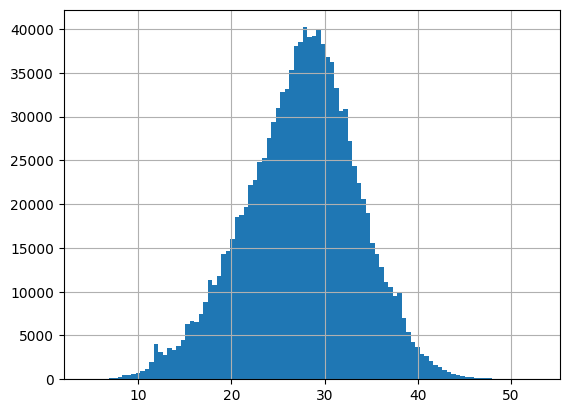

In [50]:
df_sorted.rating_at_time.hist(bins=100)

In [64]:
import japanize_matplotlib

japanize_matplotlib.japanize()


# Lag the rating_at_time by one row per horse (meta_血統登録番号) chronologically (meta_発走日時)
df_sorted["rating"] = (
    df_sorted.sort_values("meta_発走日時")
    .groupby("meta_血統登録番号")["rating_at_time"]
    .shift(1)
    .fillna(25.0)
)

<Axes: >

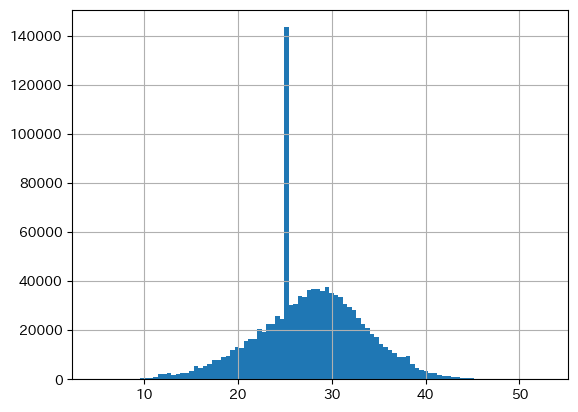

In [68]:
# 25 is the starting number for TrueSkill ratings so this number appears most often
df_sorted.rating.hist(bins=100)

In [71]:
df_final = df_sorted[
    (df_sorted["cat_トラック種別"] != "障害")
    & (df_sorted["num_1走前着順"].notnull())
    & (df_sorted["num_2走前着順"].notnull())
    & (df_sorted["num_3走前着順"].notnull())
]

In [72]:
df_final

,meta_単勝払戻金,meta_複勝払戻金,meta_レースキー,meta_馬番,meta_血統登録番号,meta_発走日時,meta_単勝的中,meta_複勝的中,meta_複勝オッズ,meta_着順,...,cat_トラック種別,num_距離,num_過去3走重み付き着順成績,num_入厩何日前逆数,cat_堅実な馬,cat_過去3走中1走訳あり凡走,cat_過去3走中2走好走,cat_過去3走繋がりあり,rating_at_time,rating
336153,0,360,06001101,05,97106623,2000-01-05 10:00:00+09:00,0,1,3.6,3.0,...,ダート,1000,0.221320,1.000000,False,False,False,False,28.52695,25.000000
565538,0,130,06001101,04,97104609,2000-01-05 10:00:00+09:00,0,1,1.2,2.0,...,ダート,1000,0.136671,1.000000,False,False,False,False,31.357209,25.000000
676049,0,0,06001101,01,97100761,2000-01-05 10:00:00+09:00,0,0,1.7,7.0,...,ダート,1000,0.218651,1.000000,False,False,True,False,18.642791,25.000000
898163,0,0,06001101,03,97100203,2000-01-05 10:00:00+09:00,0,0,4.4,8.0,...,ダート,1000,0.349326,1.000000,False,False,False,False,14.382763,25.000000
899319,0,0,06001101,07,97102626,2000-01-05 10:00:00+09:00,0,0,2.6,4.0,...,ダート,1000,0.238643,1.000000,False,False,False,False,26.137637,25.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997287,0,0,06235912,05,18103535,2023-12-28 16:25:00+09:00,0,0,NaN,4.0,...,芝,1600,0.178001,0.030303,False,False,False,False,37.98781,37.870594
1000195,3850,580,06235912,06,19100684,2023-12-28 16:25:00+09:00,1,1,NaN,1.0,...,芝,1600,0.376989,0.043478,False,False,False,False,36.571042,36.024137
1000454,0,210,06235912,01,19101408,2023-12-28 16:25:00+09:00,0,1,NaN,3.0,...,芝,1600,0.205810,0.035714,False,True,False,False,37.629243,37.372301
1002405,0,0,06235912,04,19105177,2023-12-28 16:25:00+09:00,0,0,NaN,12.0,...,芝,1600,0.020087,0.050000,False,False,True,False,36.311323,36.696487


In [74]:
from sklearn.model_selection import train_test_split


X = df_final.copy()
y = X["meta_複勝的中"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (647265, 110)
X_test: (161817, 110)
y_train: (647265,)
y_test: (161817,)


In [80]:
import mlflow
import tempfile
import re
import japanize_matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import warnings
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline
from hyperopt import STATUS_OK
from JapanHorseRaceAnalytics.utilities.metrics import (
    calculate_payout_rate,
    kelly_criterion
)

from JapanHorseRaceAnalytics.utilities.plot import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_feature_importances,
    plot_shap_interaction_values,
    plot_correlation_matrix,
)



def create_objective_fn(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    payouts: pd.DataFrame,
    payout_column_name: str,
    mlflow_experiment_name: str,
):
    """
    payouts should have the same index as *_test and have the following columns:
    * 発走日時
    * odds
    * payout
    """

    def train(params):
        mlflow.set_experiment(experiment_name=mlflow_experiment_name)
        with mlflow.start_run():
            ########################################################################################
            # decay_rate = params["features__decay_rate"]

            for df in [X_train, X_test]:
                # 1. Weighted average position
                df["num_1走前標準化着順"] = (df["num_1走前着順"] - 1) / (df["num_1走前頭数"] - 1)
                df["num_2走前標準化着順"] = (df["num_2走前着順"] - 1) / (df["num_2走前頭数"] - 1)
                df["num_3走前標準化着順"] = (df["num_3走前着順"] - 1) / (df["num_3走前頭数"] - 1)
                # We want our factor (num_1走前経過日数) to start from 0
                # so subtract the minimum value for "days since last race" across all horses
                # Add a small number to avoid division by zero
                df["num_1走前重み"] = 1 / (df["num_1走前経過日数"] - df["num_1走前経過日数"].min() + 1e-6)
                df["num_2走前重み"] = 1 / (df["num_2走前経過日数"] - df["num_1走前経過日数"].min() + 1e-6)
                df["num_3走前重み"] = 1 / (df["num_3走前経過日数"] - df["num_1走前経過日数"].min() + 1e-6)
                # df["num_2走前重み"] = np.exp(-decay_rate * (df["num_2走前経過日数"] - df["num_1走前経過日数"].min()))
                # df["num_3走前重み"] = np.exp(-decay_rate * (df["num_3走前経過日数"] - df["num_1走前経過日数"].min()))
                # Calculate weighted average of the feature
                # weighted_feature_values = np.average([value for _, value in races], weights=weights)
                df["num_過去3走重み付き標準化着順"] = (
                    (df["num_1走前標準化着順"] * df["num_1走前重み"])
                    + (df["num_2走前標準化着順"] * df["num_2走前重み"])
                    + (df["num_3走前標準化着順"] * df["num_3走前重み"])
                ) / (df["num_1走前重み"] + df["num_2走前重み"] + df["num_3走前重み"])

                # 2. Weighted average time difference between the horse and the 3 horses behind it
                df["num_1走前後続馬平均タイム差"] = (
                    df[["num_1走前後続馬1タイム差", "num_1走前後続馬2タイム差", "num_1走前後続馬3タイム差"]]
                    .mean(axis=1)
                    .fillna(0)
                )
                df["num_2走前後続馬平均タイム差"] = (
                    df[["num_2走前後続馬1タイム差", "num_2走前後続馬2タイム差", "num_2走前後続馬3タイム差"]]
                    .mean(axis=1)
                    .fillna(0)
                )
                df["num_3走前後続馬平均タイム差"] = (
                    df[["num_3走前後続馬1タイム差", "num_3走前後続馬2タイム差", "num_3走前後続馬3タイム差"]]
                    .mean(axis=1)
                    .fillna(0)
                )
                df["num_過去3走重み付き後続馬平均タイム差"] = (
                    (df["num_1走前後続馬平均タイム差"] * df["num_1走前重み"])
                    + (df["num_2走前後続馬平均タイム差"] * df["num_2走前重み"])
                    + (df["num_3走前後続馬平均タイム差"] * df["num_3走前重み"])
                ) / (df["num_1走前重み"] + df["num_2走前重み"] + df["num_3走前重み"])
            ########################################################################################
            preprocessor = ColumnTransformer(
                transformers=[
                    # (
                    #     "cat",
                    #     OneHotEncoder(drop="if_binary", handle_unknown="error"),
                    #     ["cat_性別", "cat_場コード", "cat_トラック種別"],
                    # ),
                    (
                        "num",
                        StandardScaler(),
                        [
                            "num_複勝率",
                            "num_1走前経過日数",
                            "num_過去3走重み付き標準化着順",
                            "num_過去3走重み付き後続馬平均タイム差",
                            "rating"
                        ],
                    ),
                ],
                remainder="drop",
            )

            # Get all keys from params where the key starts with "smote__" and remove "smote__" from the key
            smote_params = {k.split("__")[1]: v for k, v in params.items() if k.startswith("smote__")}

            # do the same for classifier
            classifier_params = {k.split("__")[1]: v for k, v in params.items() if k.startswith("classifier__")}

            model = ImblearnPipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("smote", SMOTE(**smote_params)),
                    ("classifier", LGBMClassifier(**classifier_params)),
                ]
            )

            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)
            y_pred = model.predict(X_test)

            metrics = {
                "loss": -precision_score(y_test, y_pred),
                "log_loss": log_loss(y_test, y_proba[:, 1]),
                "accuracy": accuracy_score(y_test, y_pred),
                "precision": precision_score(y_test, y_pred),
                "recall": recall_score(y_test, y_pred),
                "f1": f1_score(y_test, y_pred),
                "roc_auc": roc_auc_score(y_test, y_pred),
            }

            mlflow.log_params(classifier_params)
            # mlflow.log_param("decay_rate", decay_rate)
            mlflow.log_metrics(metrics)
            mlflow.sklearn.log_model(sk_model=model, artifact_path="model")

            payout = calculate_payout_rate(
                payouts=payouts,
                y_test=y_test,
                y_proba_true=y_proba[:, 1],
                groupby=[
                    ("all", None),
                    ("month", payouts["発走日時"].dt.month),
                    ("season", payouts["発走日時"].dt.month % 12 // 3),
                    ("year", payouts["発走日時"].dt.year),
                ],
                payout_column_name=payout_column_name,
            )

            # Save payout rates as csv
            with tempfile.NamedTemporaryFile(prefix="payout_rate_", suffix=".csv") as f:
                payout.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)

            # Log payout rates as metrics
            payout_metrics = {}
            for group_name, group in payout.groupby("group"):
                for i, row in group.iterrows():
                    key = re.sub(r"\W", "_", f"payout_rate_{group_name}_{row['part']}")
                    payout_metrics[key] = row["payout_rate"]
            mlflow.log_metrics(payout_metrics)

            # Suppress UserWarning messages from matplotlib
            warnings.filterwarnings("ignore", category=UserWarning)

            # Confusion Matrix
            fig, axes = plot_confusion_matrix(y_test, y_pred)
            with tempfile.NamedTemporaryFile(
                prefix="confusion_matrix_", suffix=".png"
            ) as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # ROC Curve
            fig, ax = plot_roc_curve(y_test, y_proba[:, 1])
            with tempfile.NamedTemporaryFile(prefix="roc_curve_", suffix=".png") as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Feature Importances Plot
            fig, ax = plot_feature_importances(
                preprocessor.get_feature_names_out(),
                model.named_steps["classifier"].feature_importances_,
                top_n=50,
            )
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_", suffix=".png"
            ) as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Feature Importances Data
            feature_importances = zip(
                preprocessor.get_feature_names_out(),
                model.named_steps["classifier"].feature_importances_,
            )
            feature_importances_df = (
                pd.DataFrame(feature_importances, columns=["feature", "importance"])
                .sort_values("importance", ascending=False)
                .reset_index(drop=True)
            )
            with tempfile.NamedTemporaryFile(prefix="feature_importance_", suffix=".csv") as f:
                feature_importances_df.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)
            
            # SHAP values
            X_test_sample = X_test.sample(n=5000, random_state=42)
            X_test_sample_prep = preprocessor.transform(X_test_sample)
            explainer = shap.TreeExplainer(
                model=model.named_steps["classifier"],
                feature_names=preprocessor.get_feature_names_out(),
            )
            # Because we are working with a binary classifier, we only need the SHAP values for the positive class.
            # E.g., if you change 1->0 the waterfall plot flips backwards only.
            shap_values = explainer(X_test_sample_prep)[:, :, 1]
            shap_interaction_values = explainer.shap_interaction_values(X_test_sample_prep)

            # SHAP beeswarm plot
            shap.plots.beeswarm(shap_values, show=False)
            plt.tight_layout()
            with tempfile.NamedTemporaryFile(prefix="shap_beeswarm_", suffix=".png") as f:
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # SHAP interaction values heatmap
            fig, ax = plot_shap_interaction_values(shap_interaction_values, preprocessor.get_feature_names_out())
            with tempfile.NamedTemporaryFile(prefix="shap_interactions_", suffix=".png") as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # SHAP bar plot
            shap.plots.bar(shap_values, show=False)
            plt.tight_layout()
            with tempfile.NamedTemporaryFile(prefix="shap_bar_", suffix=".png") as f:
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Correlation matrix
            fig, ax = plot_correlation_matrix(data=preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())
            with tempfile.NamedTemporaryFile(prefix="correlation_matrix_", suffix=".png") as f:
                fig.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Bankroll over time
            results = (
                pd.concat(
                    [
                        payouts,
                        pd.Series(y_pred.astype(bool)).rename("pred"),
                        pd.Series(y_proba[:, 1]).rename("proba_true"),
                        y_test.astype(bool).reset_index(drop=True).rename("actual"),
                    ],
                    axis=1,
                )
                .set_index("発走日時")
                .sort_index()
                .dropna()
            )
            b = results["odds"] - 1
            p = results["proba_true"]
            q = 1 - p
            japanize_matplotlib.japanize()
            for confidence in [0.5, 0.65, 0.8]:
                fig, ax = plt.subplots(figsize=(15, 5))
                for multiplier in [0.1, 0.2, 0.3]:
                    results[f"kelly_{multiplier}"] = kelly_criterion(b, p, q).clip(lower=0) * multiplier
                    bankroll = 10_000
                    history = []
                    for i, row in results.iterrows():
                        # bet in 100 yen increments
                        bet_amount = round(row[f"kelly_{multiplier}"] * bankroll / 100) * 100
                        bet = bet_amount > 0 and row["proba_true"] >= confidence
                        if bet and row["actual"] is True:
                            bankroll += (row["odds"] - 1) * bet_amount
                        elif bet and row["actual"] is False:
                            bankroll -= bet_amount
                        history.append(bankroll)
                    results["bankroll"] = history
                    results["bankroll"].plot(ax=ax, label=f"Kelly Criterion x {multiplier}")
                ax.set_title("Bankroll over time (Confidence: {confidence})")
                ax.set_ylabel("Bankroll")
                ax.set_xlabel("Date")
                ax.legend()
                plt.tight_layout()
                plt.grid()
                with tempfile.NamedTemporaryFile(prefix=f"bets_{confidence}_confidence_", suffix=".png") as f:
                    fig.savefig(f.name)
                    plt.close()
                    mlflow.log_artifact(f.name)
            return {"status": STATUS_OK, "params": params, "model": model, **metrics}

    return train

In [81]:
random_state = 42
from hyperopt import Trials, fmin, hp, tpe, SparkTrials
from hyperopt.pyll.base import scope

space = {
    "smote__random_state": random_state,
    # "features__decay_rate": hp.uniform("decay_rate", 0.001, 0.1),
    "classifier__boosting_type": "gbdt",
    "classifier__learning_rate": hp.loguniform("learning_rate", -5, 0),  # between e^-5 and 1
    "classifier__n_estimators": scope.int(hp.quniform("n_estimators", 100, 1000, 1)),
    "classifier__max_depth": scope.int(hp.quniform("max_depth", 3, 10, 1)),
    "classifier__num_leaves": scope.int(hp.quniform("num_leaves", 20, 150, 1)),
    "classifier__min_child_samples": scope.int(hp.quniform("min_child_samples", 20, 500, 1)),
    "classifier__feature_fraction": hp.uniform("feature_fraction", 0.5, 1.0),
    "classifier__lambda_l1": hp.uniform("lambda_l1", 0, 5),
    "classifier__lambda_l2": hp.uniform("lambda_l2", 0, 5),
    "classifier__min_split_gain": hp.uniform("min_split_gain", 0, 1),
    "classifier__min_child_weight": hp.uniform("min_child_weight", 0.001, 10),
    "classifier__subsample": hp.uniform("subsample", 0.5, 1),
    "classifier__colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "classifier__reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
    "classifier__reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
    "classifier__objective": "binary",
    "classifier__verbose": -1,
    "classifier__random_state": random_state,
}

In [82]:
payouts = (
    X_test[["meta_発走日時", "meta_複勝払戻金", "meta_複勝オッズ"]]
    .reset_index(drop=True)
    .rename(
        columns={
            "meta_発走日時": "発走日時",
            "meta_複勝払戻金": "payout",
            "meta_複勝オッズ": "odds",
        }
    )
    .assign(発走日時=lambda x: pd.to_datetime(x["発走日時"]))
)

experiment_name = "20240316-eda2"
if mlflow.get_experiment_by_name(experiment_name) is None:
    mlflow.create_experiment(experiment_name)

fn = create_objective_fn(
    X_train,
    y_train,
    X_test,
    y_test,
    payouts=payouts,
    payout_column_name="payout",
    mlflow_experiment_name=experiment_name,
)

In [84]:
# trials = Trials()
# fmin(
#     fn=fn,
#     space=space,
#     algo=tpe.suggest,
#     max_evals=1,
#     trials=trials,
# )

trials = SparkTrials(parallelism=3, spark_session=spark)
fmin(fn=fn, space=space, algo=tpe.suggest, max_evals=30, trials=trials)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

build_posterior_wrapper took 0.002001 seconds
TPE using 0 trials
build_posterior_wrapper took 0.001843 seconds
TPE using 1/1 trials with best loss inf
build_posterior_wrapper took 0.001820 seconds
TPE using 2/2 trials with best loss inf
build_posterior_wrapper took 0.001809 seconds
TPE using 3/3 trials with best loss inf
Setuptools is replacing distutils.:>    (0 + 1) / 1][Stage 2:>    (0 + 1) / 1]1]
Setuptools is replacing distutils.
Setuptools is replacing distutils.
Closing down clientserver connection                                            


  3%|▎         | 1/30 [01:29<43:03, 89.10s/trial, best loss: -0.4012363947255927]

build_posterior_wrapper took 0.002219 secondse 2:>                  (0 + 1) / 1]
TPE using 4/4 trials with best loss -0.401236
Closing down clientserver connection                                            


  7%|▋         | 2/30 [01:31<17:44, 38.03s/trial, best loss: -0.4026466242692876]

build_posterior_wrapper took 0.001729 seconds
TPE using 5/5 trials with best loss -0.402647
Setuptools is replacing distutils.:>    (0 + 1) / 1][Stage 4:>    (0 + 1) / 1]1]
Setuptools is replacing distutils.
Closing down clientserver connection                                            


 10%|█         | 3/30 [02:58<27:18, 60.67s/trial, best loss: -0.4026466242692876]

build_posterior_wrapper took 0.001977 secondse 4:>                  (0 + 1) / 1]
TPE using 6/6 trials with best loss -0.402647
Setuptools is replacing distutils.:>    (0 + 1) / 1][Stage 5:>    (0 + 1) / 1]
Closing down clientserver connection                                            


 13%|█▎        | 4/30 [03:35<22:12, 51.25s/trial, best loss: -0.4026466242692876]

build_posterior_wrapper took 0.001818 seconds
TPE using 7/7 trials with best loss -0.402647
Setuptools is replacing distutils.:>    (0 + 1) / 1][Stage 6:>    (0 + 1) / 1]1]
Closing down clientserver connection                                            


 17%|█▋        | 5/30 [04:06<18:16, 43.86s/trial, best loss: -0.4026466242692876]

build_posterior_wrapper took 0.057891 secondse 6:>                  (0 + 1) / 1]
TPE using 8/8 trials with best loss -0.402647
Setuptools is replacing distutils.:>    (0 + 1) / 1][Stage 7:>    (0 + 1) / 1]
Closing down clientserver connection                                            


 20%|██        | 6/30 [05:56<26:29, 66.23s/trial, best loss: -0.40435714086975877]

build_posterior_wrapper took 0.002164 secondse 7:>                  (0 + 1) / 1]
TPE using 9/9 trials with best loss -0.404357
Setuptools is replacing distutils.:>    (0 + 1) / 1][Stage 8:>    (0 + 1) / 1]
Closing down clientserver connection                                            


 23%|██▎       | 7/30 [06:29<21:15, 55.47s/trial, best loss: -0.4061141082229851] 

build_posterior_wrapper took 0.001864 secondse 8:>                  (0 + 1) / 1]
TPE using 10/10 trials with best loss -0.406114
Closing down clientserver connection                                            


 27%|██▋       | 8/30 [06:40<15:11, 41.43s/trial, best loss: -0.4061141082229851]

build_posterior_wrapper took 0.001882 seconds
TPE using 11/11 trials with best loss -0.406114
Setuptools is replacing distutils.:>    (0 + 1) / 1][Stage 10:>   (0 + 1) / 1]
Setuptools is replacing distutils.
Closing down clientserver connection                                            


 30%|███       | 9/30 [07:14<13:36, 38.89s/trial, best loss: -0.4061141082229851]

build_posterior_wrapper took 0.001875 seconds
TPE using 12/12 trials with best loss -0.40611410:>                 (0 + 1) / 1]
Setuptools is replacing distutils.0:>   (0 + 1) / 1][Stage 11:>   (0 + 1) / 1]
Closing down clientserver connection                                            


 33%|███▎      | 10/30 [08:15<15:13, 45.68s/trial, best loss: -0.4061141082229851]

build_posterior_wrapper took 0.002196 secondse 11:>                 (0 + 1) / 1]
TPE using 13/13 trials with best loss -0.406114
Setuptools is replacing distutils.1:>   (0 + 1) / 1][Stage 12:>   (0 + 1) / 1]
Closing down clientserver connection                                            


 37%|███▋      | 11/30 [09:18<16:11, 51.15s/trial, best loss: -0.4061141082229851]

build_posterior_wrapper took 0.002070 secondse 12:>                 (0 + 1) / 1]
TPE using 14/14 trials with best loss -0.406114
Closing down clientserver connection                                            


 40%|████      | 12/30 [09:31<11:52, 39.59s/trial, best loss: -0.4061141082229851]

build_posterior_wrapper took 0.002314 secondse 13:>                 (0 + 1) / 1]
TPE using 15/15 trials with best loss -0.406114
Setuptools is replacing distutils.
Setuptools is replacing distutils.3:>   (0 + 1) / 1][Stage 14:>   (0 + 1) / 1]
Closing down clientserver connection                                            


 43%|████▎     | 13/30 [10:22<12:08, 42.82s/trial, best loss: -0.4061141082229851]

build_posterior_wrapper took 0.001960 seconds
TPE using 16/16 trials with best loss -0.406114
Setuptools is replacing distutils.4:>   (0 + 1) / 1][Stage 15:>   (0 + 1) / 1]
Closing down clientserver connection                                            


 47%|████▋     | 14/30 [11:26<13:09, 49.33s/trial, best loss: -0.4061141082229851]

build_posterior_wrapper took 0.001871 seconds
TPE using 17/17 trials with best loss -0.406114
Closing down clientserver connection                                            


 50%|█████     | 15/30 [11:41<09:45, 39.03s/trial, best loss: -0.4061141082229851]

build_posterior_wrapper took 0.002116 seconds
TPE using 18/18 trials with best loss -0.406114
Setuptools is replacing distutils.
Closing down clientserver connection                                            


 53%|█████▎    | 16/30 [11:55<07:21, 31.54s/trial, best loss: -0.4061141082229851]

build_posterior_wrapper took 0.001985 seconds
TPE using 19/19 trials with best loss -0.406114
Setuptools is replacing distutils.
Setuptools is replacing distutils.7:>   (0 + 1) / 1][Stage 18:>   (0 + 1) / 1]
Closing down clientserver connection                                            


 57%|█████▋    | 17/30 [12:35<07:24, 34.17s/trial, best loss: -0.4061141082229851]

build_posterior_wrapper took 0.001758 seconds
TPE using 20/20 trials with best loss -0.406114
Closing down clientserver connection                                            


 60%|██████    | 18/30 [12:53<05:49, 29.13s/trial, best loss: -0.4061141082229851]

build_posterior_wrapper took 0.002167 secondse 19:>                 (0 + 1) / 1]
TPE using 21/21 trials with best loss -0.406114
Setuptools is replacing distutils.9:>   (0 + 1) / 1][Stage 20:>   (0 + 1) / 1]
Closing down clientserver connection                                            


 63%|██████▎   | 19/30 [13:05<04:23, 23.92s/trial, best loss: -0.4061141082229851]

build_posterior_wrapper took 0.001661 seconds
TPE using 22/22 trials with best loss -0.406114
Setuptools is replacing distutils.0:>   (0 + 1) / 1][Stage 21:>   (0 + 1) / 1]1]
Setuptools is replacing distutils.
Closing down clientserver connection                                            


 67%|██████▋   | 20/30 [15:02<08:38, 51.86s/trial, best loss: -0.40685640362225095]

build_posterior_wrapper took 0.002193 secondse 21:>                 (0 + 1) / 1]
TPE using 23/23 trials with best loss -0.406856
Closing down clientserver connection                                            


 70%|███████   | 21/30 [15:06<05:37, 37.46s/trial, best loss: -0.40685640362225095]

build_posterior_wrapper took 0.001826 seconds
TPE using 24/24 trials with best loss -0.406856
Setuptools is replacing distutils.2:>   (0 + 1) / 1][Stage 23:>   (0 + 1) / 1]1]
Setuptools is replacing distutils.
Closing down clientserver connection                                            


 73%|███████▎  | 22/30 [16:46<07:31, 56.45s/trial, best loss: -0.40685640362225095]

build_posterior_wrapper took 0.001966 secondse 22:>                 (0 + 1) / 1]
TPE using 25/25 trials with best loss -0.406856
Closing down clientserver connection                                            


 77%|███████▋  | 23/30 [16:56<04:57, 42.50s/trial, best loss: -0.40685640362225095]

build_posterior_wrapper took 0.001778 seconds
TPE using 26/26 trials with best loss -0.406856
Setuptools is replacing distutils.4:>   (0 + 1) / 1][Stage 25:>   (0 + 1) / 1]
Setuptools is replacing distutils.
Closing down clientserver connection                                            


 80%|████████  | 24/30 [18:10<05:12, 52.02s/trial, best loss: -0.40685640362225095]

build_posterior_wrapper took 0.001876 secondse 25:>                 (0 + 1) / 1]
TPE using 27/27 trials with best loss -0.406856
Setuptools is replacing distutils.5:>   (0 + 1) / 1][Stage 26:>   (0 + 1) / 1]
Closing down clientserver connection                                            


 83%|████████▎ | 25/30 [18:34<03:36, 43.33s/trial, best loss: -0.40685640362225095]

build_posterior_wrapper took 0.001978 seconds
TPE using 28/28 trials with best loss -0.406856
Closing down clientserver connection                                            


 87%|████████▋ | 26/30 [18:43<02:12, 33.08s/trial, best loss: -0.4071651698555252] 

build_posterior_wrapper took 0.001891 seconds
TPE using 29/29 trials with best loss -0.407165
Setuptools is replacing distutils.7:>   (0 + 1) / 1][Stage 28:>   (0 + 1) / 1]
Setuptools is replacing distutils.
Closing down clientserver connection                                            


 90%|█████████ | 27/30 [19:23<01:45, 35.31s/trial, best loss: -0.4071651698555252]

Setuptools is replacing distutils.8:>   (0 + 1) / 1][Stage 29:>   (0 + 1) / 1]1]
Closing down clientserver connection                                            


 93%|█████████▎| 28/30 [20:37<01:33, 46.85s/trial, best loss: -0.4071651698555252]

Closing down clientserver connection                                            


 97%|█████████▋| 29/30 [20:47<00:35, 35.81s/trial, best loss: -0.4071651698555252]

Closing down clientserver connection                                            


100%|██████████| 30/30 [21:12<00:00, 42.42s/trial, best loss: -0.4071651698555252]

Queue empty, exiting run.


Closing down clientserver connection
Total Trials: 30: 30 succeeded, 0 failed, 0 cancelled.


{'colsample_bytree': 0.677399013908561,
 'feature_fraction': 0.8071637093574703,
 'lambda_l1': 2.67665594102914,
 'lambda_l2': 3.126597557072865,
 'learning_rate': 0.04424450071602082,
 'max_depth': 9.0,
 'min_child_samples': 192.0,
 'min_child_weight': 4.923721937233951,
 'min_split_gain': 0.44757252280994464,
 'n_estimators': 806.0,
 'num_leaves': 79.0,
 'reg_alpha': 0.6090953254448793,
 'reg_lambda': 0.42898390673635783,
 'subsample': 0.8794492051014245}